# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.mpnn import set_custom_objects, run_model
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from keras.models import load_model
from ase.units import eV, Hartree
from time import perf_counter
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [2]:
set_custom_objects()

## Load in the Test Data
We are going to use it to validate our models

In [3]:
_, test_data = load_benchmark_data()

In [4]:
baseline_water = (test_data['sol_water'] - test_data['sol_water'].mean()).abs().mean()
print(f'Baseline: {baseline_water:.2f}')

Baseline: 3.28


## Score All Models
Run all models on the test sets, store results in DataFrame

In [5]:
models = glob(os.path.join('networks', '**', 'best_model.h5'), recursive=True)

In [6]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from directory structure
    path = Path(path)
    parents = list(path.parents)
    metadata = [p.name for p in parents[:-3]]
    metadata = dict([(x[-1], '-'.join(x[:-1])) for x in map(lambda x: x.split("-"), metadata)])
    metadata['path'] = str(path.parent)
    metadata['network'] = parents[-3].name
    
    # Convert numerical values
    for k in ['nodes', 'entries', 'batch_size']:
        metadata[k] = int(metadata[k])
    
    # Score the model on the target variable
    with open(parents[-3].joinpath('options.json')) as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent.joinpath('log.csv'))
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['cpu-hrs'] = metadata['total_time'] * metadata['nodes'] / 3600 * 64
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Check whether the network had finished training
    metadata['finished'] = os.path.isfile(path.parent.joinpath('finished'))
    
    # Load the converter
    with open(parents[-3].joinpath('converter.pkl'), 'rb') as fp:
        converter = pkl.load(fp)
    
    # Load in the model and run it on the test set
    directory = path.parent
    for name in ['best_model.h5', 'checkpoint.h5']:
        tag = '' if name.startswith('best') else '-last'
        
        try:
            model = load_model(str(path.parent.joinpath(name)))
        except OSError:
            print(f'Problem with: {path.parent.joinpath(name)}')
            continue
        start_time = perf_counter()
        y_pred = run_model(model, converter, test_data['smiles_0'], chunk_size=2048, n_jobs=4)
        metadata[f'eval_time{tag}'] = perf_counter() - start_time
        metadata[f'mae_all_outputs{tag}'] = mean_absolute_error(y_pred, test_data[output])
    
        # Get the MAE on water only
        water_col = output.index('sol_water')
        metadata[f'mae_water{tag}'] = mean_absolute_error(y_pred[:, water_col], test_data['sol_water'])
    return metadata

In [7]:
results = [score_model(x) for x in tqdm(models)]

  0%|                                                                                                                                                                             | 0/40 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
  2%|████▏                                                                                                                                                                | 1/40 [00:29<18:52, 29.04s/it]/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: Use

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 20%|█████████████████████████████████                                                                                                                                    | 8/40 [06:45<33:13, 62.31s/it]/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: Use

In [8]:
results = pd.DataFrame(results)

In [9]:
results.to_json('mpnn-results.json')

## Evaluate the Models
Make sure that our models are working as expected

In [10]:
results.sort_values('mae_water-last', ascending=True)[['network', 'mae_water-last', 'mae_water', 'finished', 'total_time',
                                                  'epochs', 'batch_size', 'median_epoch_time', 'cpu-hrs']].head(10)

,network,mae_water-last,mae_water,finished,total_time,epochs,batch_size,median_epoch_time,cpu-hrs
28,dielectric-constant-charges,0.317732,0.322646,False,78015.596523,2608,8192,29.298202,11095.551505
30,dielectric-constant-charges,0.351348,0.350329,True,49546.459699,5587,16384,8.605515,112745.721627
15,dielectric-constant-charges_no-acn,0.382010,0.379115,True,71560.724821,6824,16384,9.472028,162840.404925
8,dielectric-constant-softplus-mpnn-charges,0.428832,0.430517,True,53188.755264,6824,16384,7.474129,121033.967534
13,single-task,0.431393,0.430632,True,104667.876564,6824,16384,15.358279,238177.568003
6,dielectric-constant-softplus,0.433944,0.436004,True,48254.417017,6513,16384,7.200569,109805.606724
22,multi-task_no-acn,0.436310,0.439951,True,93550.509732,6824,16384,12.175654,212879.382145
36,multi-task,0.438842,0.438772,True,100223.862861,6749,16384,14.647366,228064.967932
39,multi-task_multi-dense,0.441430,0.440561,True,89771.366894,6824,16384,12.480558,204279.732665
2,dielectric-constant,0.448293,0.449227,True,85537.469503,6824,16384,12.127383,194645.263935


In [11]:
results.sort_values('mae_water', ascending=True).query('batch_size=="16384" and entries==117232')[['network', 'mae_water', 'mae_water-last',
                                                                              'finished', 'total_time', 'epochs', 'entries',
                                                                              'batch_size', 'median_epoch_time']].sort_values('mae_water')

,network,mae_water,mae_water-last,finished,total_time,epochs,entries,batch_size,median_epoch_time
30,dielectric-constant-charges,0.350329,0.351348,True,49546.459699,5587,117232,16384,8.605515
15,dielectric-constant-charges_no-acn,0.379115,0.382010,True,71560.724821,6824,117232,16384,9.472028
8,dielectric-constant-softplus-mpnn-charges,0.430517,0.428832,True,53188.755264,6824,117232,16384,7.474129
13,single-task,0.430632,0.431393,True,104667.876564,6824,117232,16384,15.358279
6,dielectric-constant-softplus,0.436004,0.433944,True,48254.417017,6513,117232,16384,7.200569
36,multi-task,0.438772,0.438842,True,100223.862861,6749,117232,16384,14.647366
22,multi-task_no-acn,0.439951,0.436310,True,93550.509732,6824,117232,16384,12.175654
39,multi-task_multi-dense,0.440561,0.441430,True,89771.366894,6824,117232,16384,12.480558
2,dielectric-constant,0.449227,0.448293,True,85537.469503,6824,117232,16384,12.127383
31,dielectric-constant-softplus-mpnn-charges_no-acn,0.455521,0.451148,False,47970.891588,6039,117232,16384,7.642110


### Plot the Learning as Function of Epoch
Look for anomalous behavior

networks/dielectric-constant-charges/32786-entries/128-nodes/16384-batch_size best loss after 6283 epochs was at 6168 epochs: 0.5740481860692561
networks/dielectric-constant-charges/117232-entries/1-nodes/1024-batch_size best loss after 57 epochs was at 53 epochs: 1.3377138539736932
networks/dielectric-constant-charges/117232-entries/8-nodes/8192-batch_size best loss after 2608 epochs was at 2121 epochs: 0.1582509086529922
networks/dielectric-constant-charges/117232-entries/128-nodes/32768-batch_size best loss after 1426 epochs was at 1037 epochs: 1.3072691708396458
networks/dielectric-constant-charges/117232-entries/128-nodes/16384-batch_size best loss after 5587 epochs was at 4096 epochs: 0.2873680436648797


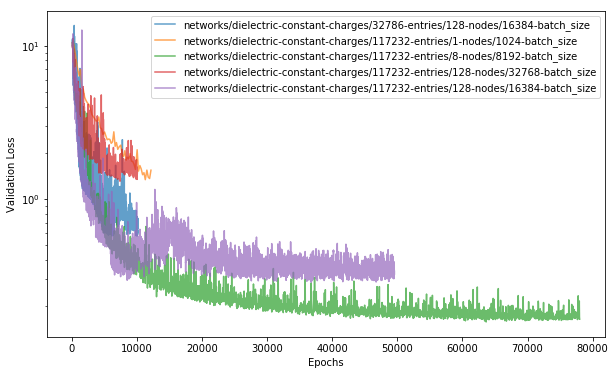

In [12]:
fig, ax = plt.subplots()

for f in results.query('network=="dielectric-constant-charges"')['path']:
    name = os.path.dirname(f)
    log = pd.read_csv(os.path.join(f, 'log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(name, len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.semilogy(log['epoch_time'].cumsum(), log['val_loss'], label=name, alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(10, 6)

networks/dielectric-constant/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6824 epochs was at 4780 epochs: 0.3360591670469654
networks/dielectric-constant-softplus/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6513 epochs was at 3998 epochs: 0.3355724524995118
networks/dielectric-constant-mpnn-charges/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6824 epochs was at 2309 epochs: 0.4317965967773232
networks/dielectric-constant-softplus-mpnn-charges/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6824 epochs was at 5565 epochs: 0.3366845613609235
networks/single-task/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6824 epochs was at 4857 epochs: 0.4929482457706217
networks/dielectric-constant-charges_no-acn/117232-entries/128-nodes/16384-batch_size/1.00e-04-learning_rate best loss after 6824 epochs was at 3391 epochs: 0.

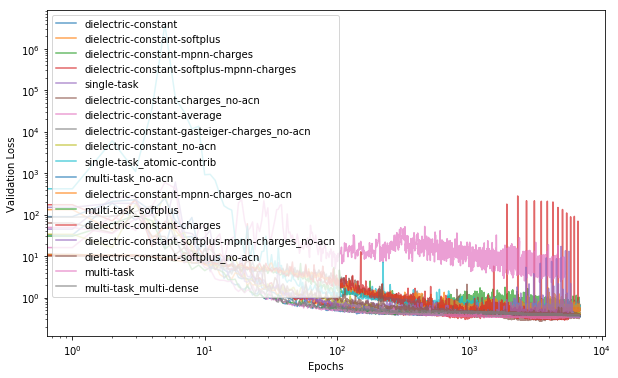

In [13]:
fig, ax = plt.subplots()

for _, f in results.query('batch_size=="16384" and nodes==128 and entries==117232').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(f['path'], len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.loglog(log['epoch'], log['val_loss'], label=f['network'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
#ax.set_xlim(0, 2000)
ax.legend()
fig.set_size_inches(10, 6)

networks/dielectric-constant/117232-entries/8-nodes/8192-batch_size best loss after 308 epochs was at 214 epochs: 0.3794767782498813
networks/dielectric-constant-softplus/117232-entries/8-nodes/8192-batch_size best loss after 1640 epochs was at 1394 epochs: 0.3292013367073034
networks/dielectric-constant-charges_no-acn/117232-entries/8-nodes/8192-batch_size best loss after 21 epochs was at 19 epochs: 4.422829394005379
networks/dielectric-constant-average/117232-entries/8-nodes/8192-batch_size best loss after 205 epochs was at 202 epochs: 0.5358732139665654
networks/dielectric-constant-charges/117232-entries/8-nodes/8192-batch_size best loss after 2608 epochs was at 2121 epochs: 0.1582509086529922
networks/dielectric-constant-softplus_no-acn/117232-entries/8-nodes/8192-batch_size best loss after 122 epochs was at 112 epochs: 0.5305050048673368


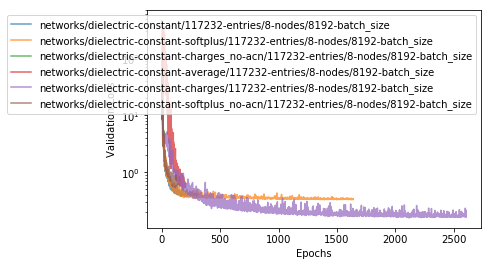

In [14]:
fig, ax = plt.subplots()

for f in results.query('batch_size=="8192"')['path']:
    if not 'dielectric' in f: continue
    name = os.path.dirname(f)
    log = pd.read_csv(os.path.join(f, 'log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(name, len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.semilogy(log['epoch'], log['val_loss'], label=name, alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(6, 4)